### Preliminaries

This example shows both the use of individual transformers and the `TimeSeriesFeatures` convenience class that wraps multiple transformers. Both methods are compatible with Scikit-Learn `Pipeline` objects.

It uses the Macrodata dataset from `Statsmodels`, which includes quarterly US Macroeconomic Data from 1950 through 2009.

In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import statsmodels.datasets
from sklearn.linear_model import LinearRegression, Lasso, PoissonRegressor
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error
import matplotlib.pyplot as plt
from sklearn.datasets import make_regression
from statsmodels.tsa.arima_process import arma_generate_sample
from sklearn.preprocessing import MinMaxScaler, StandardScaler

from steps.forward import ForwardSelector

from tsfeast.transformers import DateTimeFeatures, InteractionFeatures, LagFeatures
from tsfeast.tsfeatures import TimeSeriesFeatures
from tsfeast.funcs import get_datetime_features
from tsfeast.utils import plot_diag
from tsfeast.models import ARMARegressor

In [2]:
def make_dummy_data(n=200):
    n_lags = 2
    coefs = {'ar': [1, -0.85], 'ma': [1, 0], 'trend': 3.2, 'bdays_in_month': 231, 'marketing': 0.0026}
    rng = np.random.default_rng(seed=42)
    
    sales = pd.DataFrame({
        'date': pd.date_range(end='2020-08-31', periods=n, freq='M'),
        'sales_base': rng.poisson(200, n),
        'sales_ar': arma_generate_sample(ar=coefs['ar'], ma=coefs['ma'], nsample=n, scale=100),
        'sales_trend': [x * coefs['trend'] + rng.poisson(300) for x in range(1, n+1)],
    })
    
    sales = sales.join(get_datetime_features(sales['date'])[['bdays_in_month', 'quarter']])
    sales['sales_per_day'] = sales['bdays_in_month'] * coefs['bdays_in_month'] + rng.poisson(100, n)
    
    sales['mkt_base'] = rng.normal(1e6, 1e4, n)
    sales['mkt_trend'] = np.array([x * 5e3 for x in range(1, n+1)]) + rng.poisson(100)
    sales['mkt_season'] = np.where(sales['quarter'] == 3, sales['mkt_base'] * .35, 0)
    sales['mkt_total'] = sales.loc[:, 'mkt_base': 'mkt_season'].sum(1) + rng.poisson(100, n)
    sales['sales_mkting'] = sales['mkt_total'].shift(n_lags) * coefs['marketing']
    
    final = pd.DataFrame({
        'y': sales[['sales_base', 'sales_ar', 'sales_trend', 'sales_per_day', 'sales_mkting']].sum(1).astype(int),
        'date': sales['date'],
        'marketing': sales['mkt_total'],
        'x2': rng.random(n),
        'x3': rng.normal(loc=320, scale=4, size=n)
    })
    return sales.iloc[2:, :], final.iloc[2:, :]

In [3]:
comps, data = make_dummy_data()

In [4]:
comps.head()

,date,sales_base,sales_ar,sales_trend,bdays_in_month,quarter,sales_per_day,mkt_base,mkt_trend,mkt_season,mkt_total,sales_mkting
2,2004-03-31,211,153.620257,285.6,23,1,5402,1.012456e+06,15128.0,0.000000,1.027692e+06,2584.285914
3,2004-04-30,181,18.958345,300.8,22,2,5180,1.009596e+06,20128.0,0.000000,1.029835e+06,2661.116408
4,2004-05-31,195,54.420246,312.0,20,2,4726,9.848525e+05,25128.0,0.000000,1.010071e+06,2672.000109
5,2004-06-30,206,31.100042,326.2,22,2,5195,1.008291e+06,30128.0,0.000000,1.038529e+06,2677.570754
6,2004-07-31,198,34.283905,317.4,21,3,4952,1.004049e+06,35128.0,351416.992807,1.390691e+06,2626.185776


Column: date


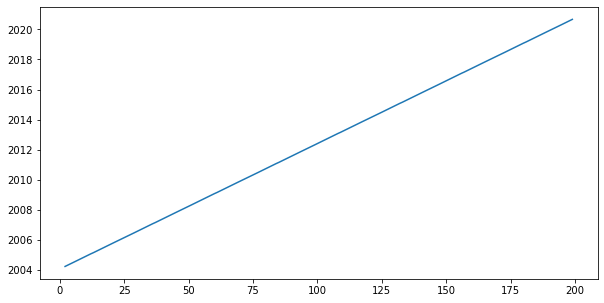

Column: sales_base


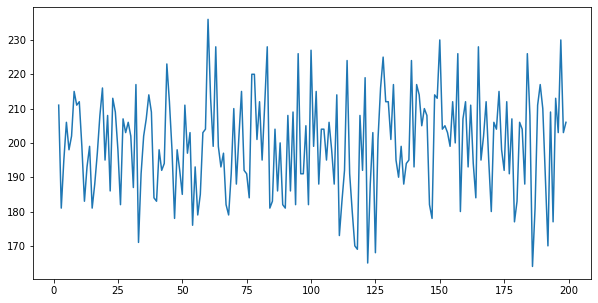

Column: sales_ar


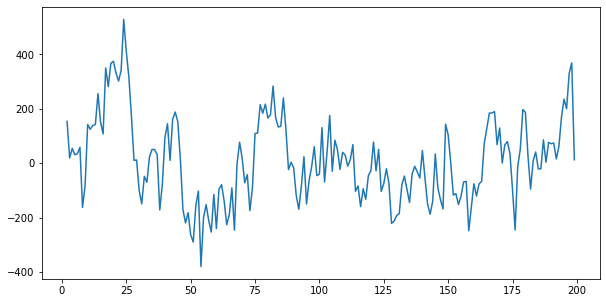

Column: sales_trend


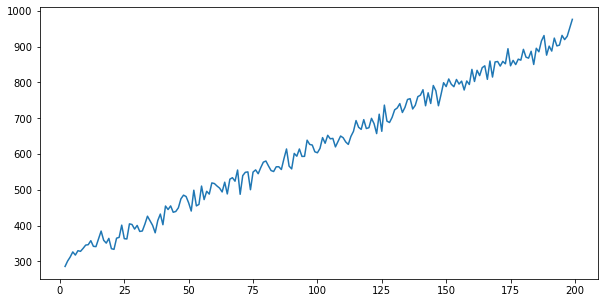

Column: bdays_in_month


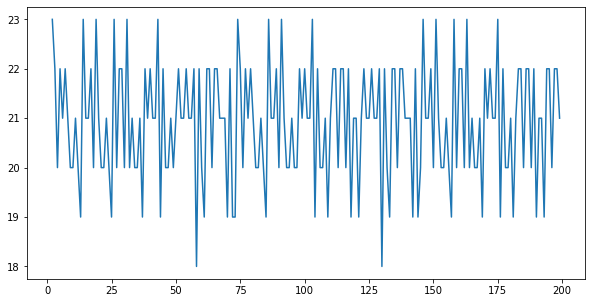

Column: quarter


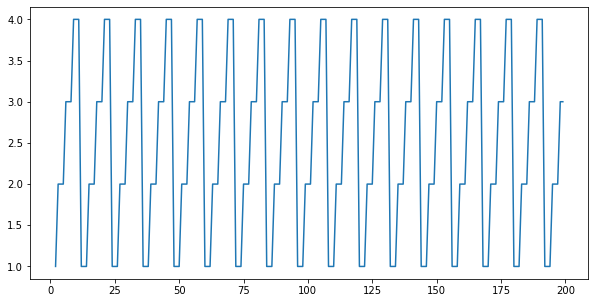

Column: sales_per_day


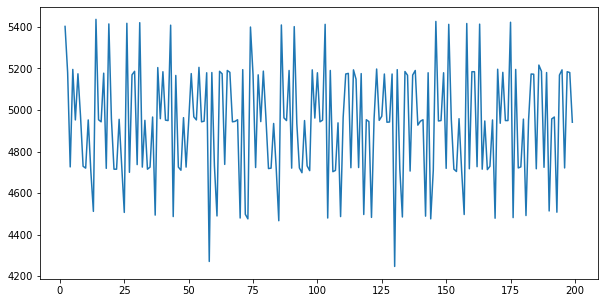

Column: mkt_base


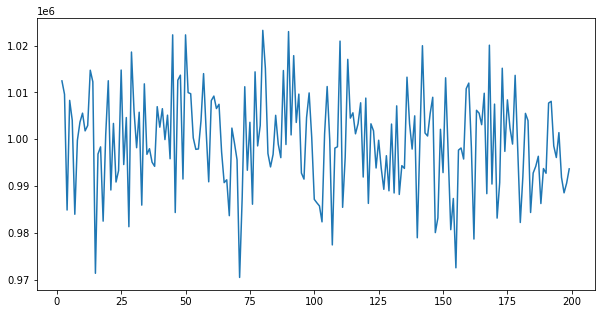

Column: mkt_trend


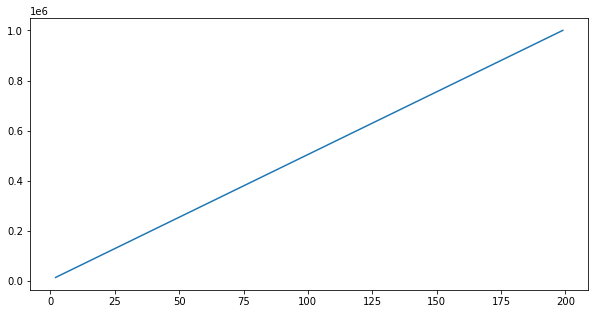

Column: mkt_season


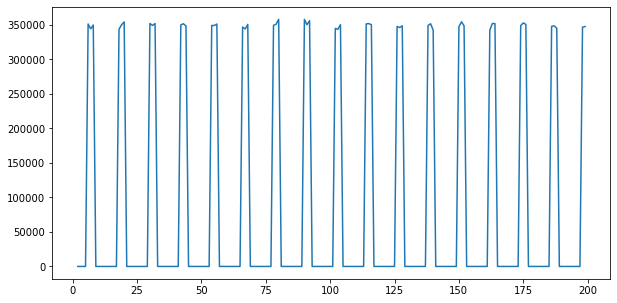

Column: mkt_total


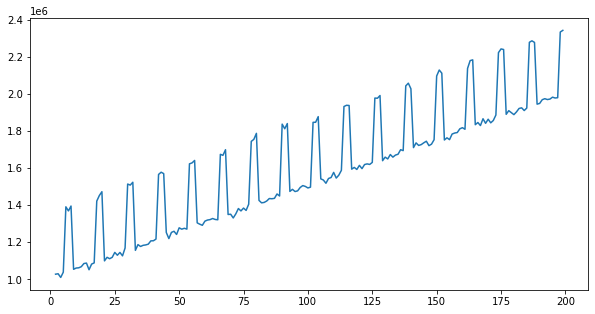

Column: sales_mkting


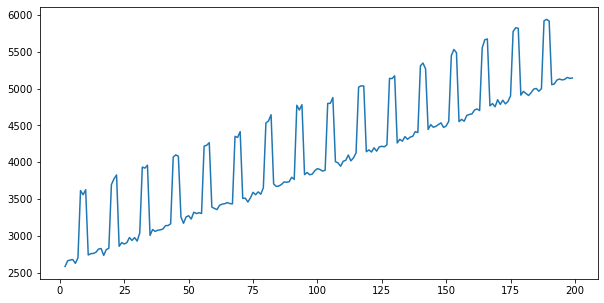

In [5]:
for col in comps.columns:
    print(f'Column: {col}')
    plt.figure(figsize=(10, 5))
    plt.plot(comps[col])
    plt.show()

In [6]:
data.head()

,y,date,marketing,x2,x3
2,8636,2004-03-31,1.027692e+06,0.716752,316.389974
3,8341,2004-04-30,1.029835e+06,0.466509,318.780107
4,7959,2004-05-31,1.010071e+06,0.361299,324.917503
5,8435,2004-06-30,1.038529e+06,0.852623,316.776026
6,8127,2004-07-31,1.390691e+06,0.571951,314.425310


Column: y


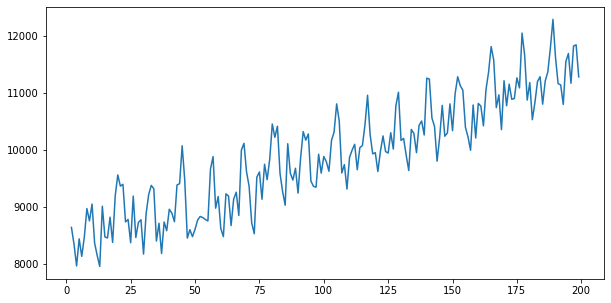

Column: date


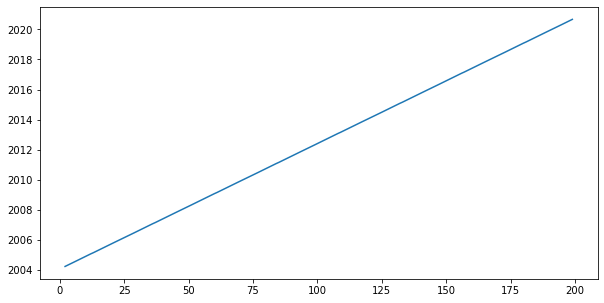

Column: marketing


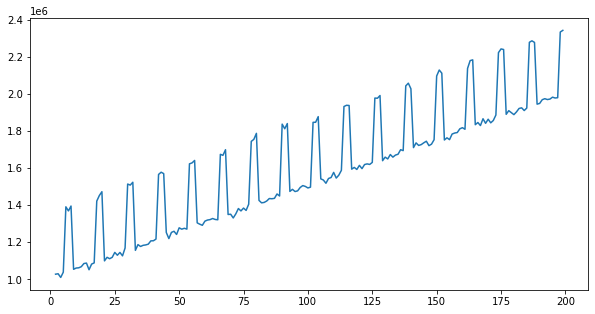

Column: x2


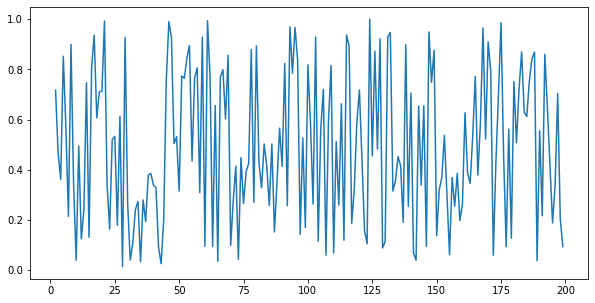

Column: x3


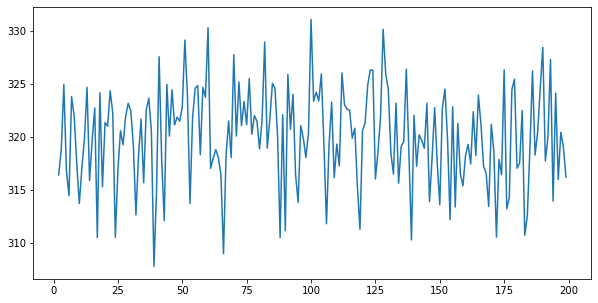

In [7]:
for col in data.columns:
    print(f'Column: {col}')
    plt.figure(figsize=(10, 5))
    plt.plot(data[col])
    plt.show()

In [8]:
X = data.iloc[:, 1:]
y = data.iloc[:, 0]
x_train, x_test = X.iloc[:-40, :], X.iloc[-40:, :]
y_train, y_test = y.iloc[:-40], y.iloc[-40:]

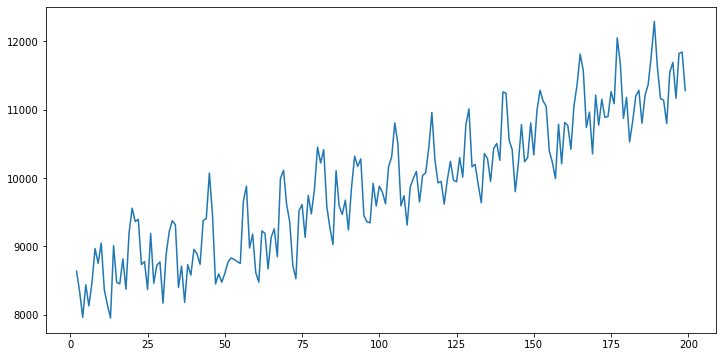

In [9]:
plt.figure(figsize=(12, 6))
plt.plot(y)
plt.show()

### Individual Transformers

#### Generate DateTime Features

In [10]:
dt = DateTimeFeatures(date_col='date')
dt.fit_transform(X, y)

,year,quarter,month,days_in_month,bdays_in_month,leap_year
2,2004,1,3,31,23,1
3,2004,2,4,30,22,1
4,2004,2,5,31,20,1
5,2004,2,6,30,22,1
6,2004,3,7,31,21,1
...,...,...,...,...,...,...
195,2020,2,4,30,22,1
196,2020,2,5,31,20,1
197,2020,2,6,30,22,1
198,2020,3,7,31,22,1


#### Generate Interaction Features

In [11]:
feat = LagFeatures(n_lags=4)
feat.fit_transform(X.iloc[:, 1:], y)

,marketing_lag_1,x2_lag_1,x3_lag_1,marketing_lag_2,x2_lag_2,x3_lag_2,marketing_lag_3,x2_lag_3,x3_lag_3,marketing_lag_4,x2_lag_4,x3_lag_4
2,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,0.000000
3,1.027692e+06,0.716752,316.389974,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,0.000000
4,1.029835e+06,0.466509,318.780107,1.027692e+06,0.716752,316.389974,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,0.000000
5,1.010071e+06,0.361299,324.917503,1.029835e+06,0.466509,318.780107,1.027692e+06,0.716752,316.389974,0.000000e+00,0.000000,0.000000
6,1.038529e+06,0.852623,316.776026,1.010071e+06,0.361299,324.917503,1.029835e+06,0.466509,318.780107,1.027692e+06,0.716752,316.389974
...,...,...,...,...,...,...,...,...,...,...,...,...
195,1.971301e+06,0.420222,313.911203,1.968782e+06,0.648398,327.288221,1.973312e+06,0.860346,319.932653,1.967943e+06,0.216269,317.692606
196,1.981624e+06,0.188104,324.110324,1.971301e+06,0.420222,313.911203,1.968782e+06,0.648398,327.288221,1.973312e+06,0.860346,319.932653
197,1.977056e+06,0.339024,315.926738,1.981624e+06,0.188104,324.110324,1.971301e+06,0.420222,313.911203,1.968782e+06,0.648398,327.288221
198,1.978757e+06,0.703778,320.409889,1.977056e+06,0.339024,315.926738,1.981624e+06,0.188104,324.110324,1.971301e+06,0.420222,313.911203


### TimeSeriesFeatures Class


In [12]:
feat = TimeSeriesFeatures(
    datetime='date',
    trend='t',
    lags=4,
    interactions=False,
    polynomial=3
)
features = feat.fit_transform(X, y)

In [13]:
features.head()

,trend,original__marketing,original__x2,original__x3,datetime__year,datetime__quarter,datetime__month,datetime__days_in_month,datetime__bdays_in_month,datetime__leap_year,...,features__lags__x3_lag_3,features__lags__marketing_lag_4,features__lags__x2_lag_4,features__lags__x3_lag_4,features__polynomial__marketing^2,features__polynomial__x2^2,features__polynomial__x3^2,features__polynomial__marketing^3,features__polynomial__x2^3,features__polynomial__x3^3
0,1.0,1.027692e+06,0.716752,316.389974,2004.0,1.0,3.0,31.0,23.0,1.0,...,0.000000,0.000000e+00,0.000000,0.000000,1.056152e+12,0.513733,100102.615631,1.085399e+18,0.368219,3.167146e+07
1,2.0,1.029835e+06,0.466509,318.780107,2004.0,2.0,4.0,30.0,22.0,1.0,...,0.000000,0.000000e+00,0.000000,0.000000,1.060560e+12,0.217631,101620.756699,1.092202e+18,0.101527,3.239468e+07
2,3.0,1.010071e+06,0.361299,324.917503,2004.0,2.0,5.0,31.0,20.0,1.0,...,0.000000,0.000000e+00,0.000000,0.000000,1.020244e+12,0.130537,105571.383672,1.030520e+18,0.047163,3.430199e+07
3,4.0,1.038529e+06,0.852623,316.776026,2004.0,2.0,6.0,30.0,22.0,1.0,...,316.389974,0.000000e+00,0.000000,0.000000,1.078543e+12,0.726966,100347.050373,1.120098e+18,0.619827,3.178754e+07
4,5.0,1.390691e+06,0.571951,314.425310,2004.0,3.0,7.0,31.0,21.0,1.0,...,318.780107,1.027692e+06,0.716752,316.389974,1.934020e+12,0.327128,98863.275608,2.689624e+18,0.187101,3.108512e+07


In [14]:
[x for x in features.columns]

['trend',
 'original__marketing',
 'original__x2',
 'original__x3',
 'datetime__year',
 'datetime__quarter',
 'datetime__month',
 'datetime__days_in_month',
 'datetime__bdays_in_month',
 'datetime__leap_year',
 'features__lags__marketing_lag_1',
 'features__lags__x2_lag_1',
 'features__lags__x3_lag_1',
 'features__lags__marketing_lag_2',
 'features__lags__x2_lag_2',
 'features__lags__x3_lag_2',
 'features__lags__marketing_lag_3',
 'features__lags__x2_lag_3',
 'features__lags__x3_lag_3',
 'features__lags__marketing_lag_4',
 'features__lags__x2_lag_4',
 'features__lags__x3_lag_4',
 'features__polynomial__marketing^2',
 'features__polynomial__x2^2',
 'features__polynomial__x3^2',
 'features__polynomial__marketing^3',
 'features__polynomial__x2^3',
 'features__polynomial__x3^3']

In [15]:
feat = TimeSeriesFeatures(
    datetime='date',
    trend='t',
    lags=4,
    interactions=False
)

pl = Pipeline([
    ('feature_extraction', feat),
    ('scaler', StandardScaler()),
    ('feature_selection', ForwardSelector(metric='bic')),
    ('regression', LinearRegression())
])

pl.fit(x_train, y_train)

Pipeline(steps=[('feature_extraction',
                 TimeSeriesFeatures(datetime='date', interactions=False, lags=4,
                                    trend='t')),
                ('scaler', StandardScaler()),
                ('feature_selection', ForwardSelector(metric='bic')),
                ('regression', LinearRegression())])

In [16]:
pl.named_steps.feature_extraction.output_features_

,trend,original__marketing,original__x2,original__x3,datetime__year,datetime__quarter,datetime__month,datetime__days_in_month,datetime__bdays_in_month,datetime__leap_year,...,features__lags__x3_lag_1,features__lags__marketing_lag_2,features__lags__x2_lag_2,features__lags__x3_lag_2,features__lags__marketing_lag_3,features__lags__x2_lag_3,features__lags__x3_lag_3,features__lags__marketing_lag_4,features__lags__x2_lag_4,features__lags__x3_lag_4
0,1.0,1.027692e+06,0.716752,316.389974,2004.0,1.0,3.0,31.0,23.0,1.0,...,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,0.000000
1,2.0,1.029835e+06,0.466509,318.780107,2004.0,2.0,4.0,30.0,22.0,1.0,...,316.389974,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,0.000000
2,3.0,1.010071e+06,0.361299,324.917503,2004.0,2.0,5.0,31.0,20.0,1.0,...,318.780107,1.027692e+06,0.716752,316.389974,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,0.000000
3,4.0,1.038529e+06,0.852623,316.776026,2004.0,2.0,6.0,30.0,22.0,1.0,...,324.917503,1.029835e+06,0.466509,318.780107,1.027692e+06,0.716752,316.389974,0.000000e+00,0.000000,0.000000
4,5.0,1.390691e+06,0.571951,314.425310,2004.0,3.0,7.0,31.0,21.0,1.0,...,316.776026,1.010071e+06,0.361299,324.917503,1.029835e+06,0.466509,318.780107,1.027692e+06,0.716752,316.389974
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
153,154.0,1.752743e+06,0.060631,322.823879,2016.0,4.0,12.0,31.0,21.0,1.0,...,312.156618,1.750890e+06,0.537173,319.820019,2.110972e+06,0.368344,324.492379,2.127929e+06,0.320161,322.674221
154,155.0,1.782890e+06,0.368878,313.360448,2017.0,1.0,1.0,31.0,20.0,0.0,...,322.823879,1.762560e+06,0.296868,312.156618,1.750890e+06,0.537173,319.820019,2.110972e+06,0.368344,324.492379
155,156.0,1.788336e+06,0.254549,321.235197,2017.0,1.0,2.0,28.0,19.0,0.0,...,313.360448,1.752743e+06,0.060631,322.823879,1.762560e+06,0.296868,312.156618,1.750890e+06,0.537173,319.820019
156,157.0,1.790967e+06,0.385921,316.450145,2017.0,1.0,3.0,31.0,23.0,0.0,...,321.235197,1.782890e+06,0.368878,313.360448,1.752743e+06,0.060631,322.823879,1.762560e+06,0.296868,312.156618


In [17]:
def get_results(estimator, x_train, x_test, y_train, y_test):
    return pd.DataFrame(
        {
            'training': [
                mean_absolute_error(y_train, estimator.predict(x_train)), 
                mean_absolute_percentage_error(y_train, estimator.predict(x_train))
            ],
            'testing':  [
                mean_absolute_error(y_test, estimator.predict(x_test)), 
                mean_absolute_percentage_error(y_test, estimator.predict(x_test))
            ],
        },
        index = ['MAE', 'MAPE']
    )

In [18]:
new_features = pl.named_steps.feature_extraction.feature_names_
mask = pl.named_steps.feature_selection.get_support()
new_features[mask]

Index(['trend', 'datetime__bdays_in_month', 'features__lags__marketing_lag_2',
       'features__lags__x3_lag_2'],
      dtype='object')

In [19]:
get_results(pl, x_train, x_test, y_train, y_test)

,training,testing
MAE,373.819325,201.999695
MAPE,0.040046,0.017827


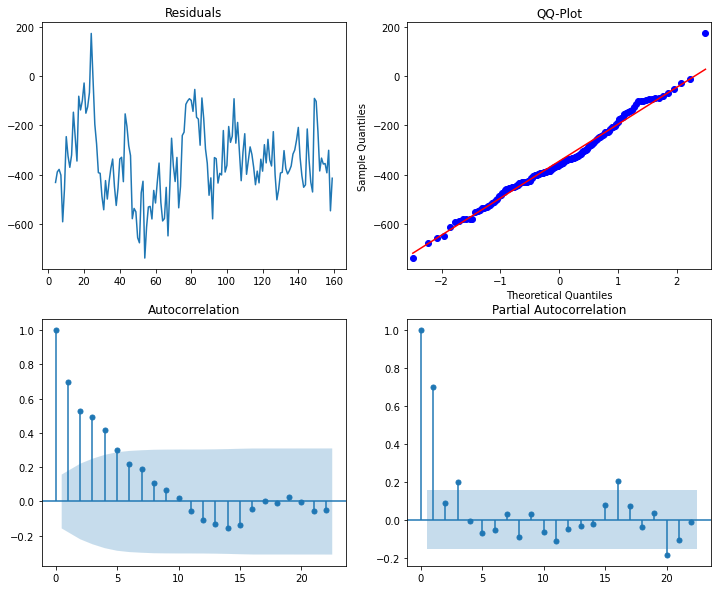

In [20]:
resid = (y_train - pl.predict(x_train))
plot_diag(resid.iloc[2:])  # throw out first two residuals b/c of lags

In [21]:
feat = TimeSeriesFeatures(
    datetime='date',
    trend='t',
    lags=4,
    interactions=False
)

mod = ARMARegressor(
    estimator=PoissonRegressor(),
    order=(1,0,0)
)

pl = Pipeline([
    ('feature_extraction', feat),
    ('scaler', StandardScaler()),
    ('feature_selection', ForwardSelector(metric='bic')),
    ('regression', mod)
])

pl.fit(x_train, y_train)

Pipeline(steps=[('feature_extraction',
                 TimeSeriesFeatures(datetime='date', interactions=False, lags=4,
                                    trend='t')),
                ('scaler', StandardScaler()),
                ('feature_selection', ForwardSelector(metric='bic')),
                ('regression', ARMARegressor(estimator=PoissonRegressor()))])

In [22]:
new_features = pl.named_steps.feature_extraction.feature_names_
mask = pl.named_steps.feature_selection.get_support()
new_features[mask]

Index(['trend', 'datetime__bdays_in_month', 'features__lags__marketing_lag_2',
       'features__lags__x3_lag_2'],
      dtype='object')

In [23]:
get_results(pl, x_train, x_test, y_train, y_test)

,training,testing
MAE,409.572082,143.269046
MAPE,0.043573,0.012745


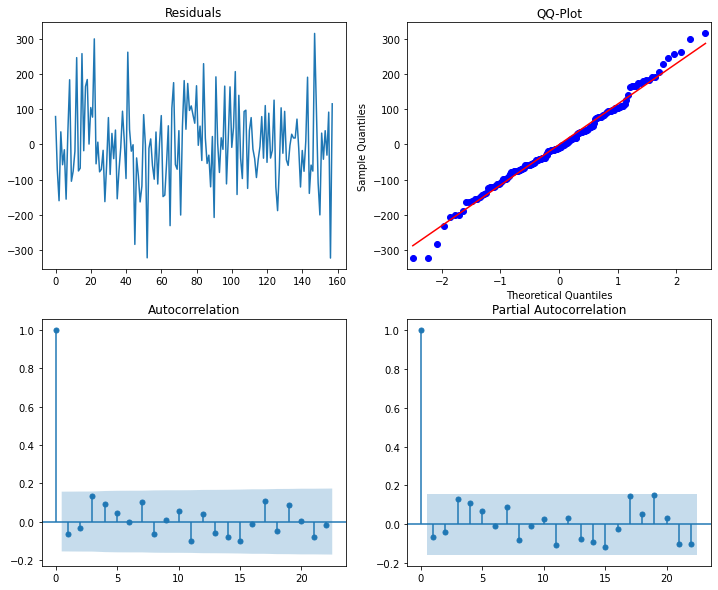

In [24]:
plot_diag(pl.named_steps.regression.resid_)